In [15]:
from sentence_transformers import SentenceTransformer
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Embedding, Masking, Lambda, Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from pathlib import Path
import os
import itertools
from importnb import Notebook, reload
with Notebook(): 
    import Utilities

In [3]:
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [4]:
# Load data 
news_path = Path("../Datasets/data/financial_headlines_20061020-20131119.pkl")
data = pd.DataFrame(pd.read_pickle(news_path))
data.set_index('date',inplace=True)

In [5]:
path = Path("../Input Data/all_reuters_news_embedded_bert_base_nli_mean.npy")
if os.path.exists(path):
    x = np.load(path)
    embed_dim = x.shape[-1]
    max_nbr_titles = x.shape[-2]
    print("Loaded previously saved embeddings.")
else:
    texts = []
    for i,date in enumerate(data.index.drop_duplicates()): 
        if i % 100: 
            print("{} % ...".format(round(100 * i / len(data.index.drop_duplicates()),3)),end='\r')
        temp_titles = []
        for title in data.loc[date].values:
            temp_titles.append(title[0])
        texts.append(sbert_model.encode(temp_titles))
    print("100 % ...")
    max_nbr_titles = max([len(text) for text in texts])
    embed_dim = texts[0][0].shape[0]
    x = np.zeros((n,max_nbr_titles,embed_dim))
    # Include embeddings in matrix and pad with (tensors) of zeros. 
    for i,titles in enumerate(texts): 
        for j,title in enumerate(titles): 
            x[i,j] = title
    np.save(path,x)

Loaded previously saved embeddings.


In [6]:
config = {
    'embed_dim': embed_dim,    # Dimensions to use for the word embedding
    'max_len': max_nbr_titles,
    'lookback': 1,        # How far back to collect data in the recurrent layer (days)
    'delay': 1,           # How far ahead to predict data (days)
    'p': 1,               # Order of the AR-part of the model
    'd': 1,               # Integrated order
    'q': 1,               # Included moving average terms 
    'train_part' : 0.8,   # Part of data to be used for training
    'val_part' : 0.1,     # Part of data to be used for validation
    'test_part' : 0.1,    # Part of data to be used for testing
    'series': '1 YEAR',   # What series we currently want to predict, '1 YEAR', '3 YEAR' or 'S&P'
    'start_date': '2006-10-20',
    'end_date': '2013-11-19',
}

In [7]:
y = Utilities.load_binary_labels(config)

Loaded previously constructed labels.


In [8]:
# Need to remove some rows from the word embedding-matrix,
# these numbers are specified in Utilities.fit_all_models()
rm_start_rows = max(config['lookback'],5) + 1
rm_end_rows = config['delay']
x = x[rm_start_rows : -rm_end_rows]

In [9]:
(x_train, y_train), (x_test, y_test) = Utilities.shuffle_and_partition(x,y,test_part = config['test_part'])
print("Shape of x_train:",x_train.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of x_test:",x_test.shape)
print("Shape of y_test:",y_test.shape)

Shape of x_train: (2317, 104, 768)
Shape of y_train: (2317,)
Shape of x_test: (258, 104, 768)
Shape of y_test: (258,)


In [10]:
# Create functions for custom 'MergeEmedding'-layer which averages 
# the embeddings over all words after the embedding layer 

def merge_embeddings(x):
    # Sum the embeddings for every word slot. If this is zero, there is no word in this slot
    non_zero = K.sum(K.cast(K.not_equal(K.sum(x,axis=2),0),tf.float32))
    return K.sum(x,axis=1) / non_zero


def merge_output_shape(input_shape):
    return (input_shape[0], input_shape[2])

In [11]:
def create_nn(n_nodes, lr=0.001):
    # n_nodes is a list with the number of nodes per layer, starting from the input 
    model = Sequential()
    model.add(Lambda(merge_embeddings, merge_output_shape, input_shape=x_train.shape[1:]))
    for n in n_nodes:
        model.add(Dense(n,activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    rms = optimizers.RMSprop(learning_rate=lr)
    model.compile(optimizer=rms, loss='binary_crossentropy', metrics=['acc'])
    return model

def train_and_format(x,y,bs,epochs, results, layers, nodes,lr,verbose):
    name = f"{bs}_{layers}_{nodes}"
    temp_history = model.fit(x, y, batch_size=bs, validation_split=0.2, epochs = epochs,verbose=verbose)
    return results.append(pd.Series([np.mean(temp_history.history['val_acc'][-5:]),
                                     temp_history,model,
                                     layers,nodes,
                                     bs, lr],name=name,
                                    index=['Mean Val Acc','History','Model','Layers','Nodes','Batch Size','Learning Rate']))


In [12]:
n_layers = [2]
n_nodes = [50, 200, 500]
learning_rates = [0.0001]
batch_sizes = [64]
verbose = 1 
epochs = 20
results = pd.DataFrame(columns=['Mean Val Acc','History','Model', 'Layers', 'Nodes','Batch Size','Learning Rate'])
n_configs = sum([len(n_nodes)**l for l in n_layers]) * len(batch_sizes) * len(learning_rates)
ctr = 0
print('Testing {} combinations. '.format(n_configs))
for layers in n_layers:
    if layers == 1: node_configs = list(itertools.product(n_nodes))
    elif layers == 2: node_configs = list(itertools.product(n_nodes, n_nodes))
    elif layers == 3: node_configs = list(itertools.product(n_nodes, n_nodes, n_nodes))
    elif layers == 4: node_configs = list(itertools.product(n_nodes, n_nodes, n_nodes, n_nodes))
    for bs in batch_sizes: 
        for temp_nodes in node_configs:
            for lr in learning_rates: 
                ctr += 1 
                model = create_nn(temp_nodes, lr)
                results = train_and_format(x_train, y_train, bs, epochs, results, layers, temp_nodes, lr,verbose=verbose)
                print("{} %     ".format(round(100 * ctr / n_configs,2)),end='\r')
            
            

Testing 9 combinations. 
Train on 1853 samples, validate on 464 samples
Epoch 1/20
1853/1853 [==============================] - 1s 596us/sample - loss: 0.6878 - acc: 0.6589 - val_loss: 0.6829 - val_acc: 0.6616
Epoch 2/20
1853/1853 [==============================] - 1s 313us/sample - loss: 0.6802 - acc: 0.6649 - val_loss: 0.6756 - val_acc: 0.6616
Epoch 3/20
1853/1853 [==============================] - 1s 310us/sample - loss: 0.6735 - acc: 0.6649 - val_loss: 0.6689 - val_acc: 0.6616
Epoch 4/20
1853/1853 [==============================] - 1s 316us/sample - loss: 0.6670 - acc: 0.6649 - val_loss: 0.6630 - val_acc: 0.6616
Epoch 5/20
1853/1853 [==============================] - 1s 305us/sample - loss: 0.6615 - acc: 0.6649 - val_loss: 0.6588 - val_acc: 0.6616
Epoch 6/20
1853/1853 [==============================] - 1s 307us/sample - loss: 0.6580 - acc: 0.6649 - val_loss: 0.6559 - val_acc: 0.6616
Epoch 7/20
1853/1853 [==============================] - 1s 316us/sample - loss: 0.6550 - acc: 0.6649

Epoch 19/20
1853/1853 [==============================] - 1s 325us/sample - loss: 0.6329 - acc: 0.6649 - val_loss: 0.6358 - val_acc: 0.6616
Epoch 20/20
1853/1853 [==============================] - 1s 304us/sample - loss: 0.6319 - acc: 0.6649 - val_loss: 0.6351 - val_acc: 0.6616
Train on 1853 samples, validate on 464 samples
Epoch 1/20
1853/1853 [==============================] - 1s 639us/sample - loss: 0.6815 - acc: 0.6649 - val_loss: 0.6725 - val_acc: 0.6616
Epoch 2/20
1853/1853 [==============================] - 1s 350us/sample - loss: 0.6682 - acc: 0.6649 - val_loss: 0.6619 - val_acc: 0.6616
Epoch 3/20
1853/1853 [==============================] - 1s 353us/sample - loss: 0.6596 - acc: 0.6649 - val_loss: 0.6567 - val_acc: 0.6616
Epoch 4/20
1853/1853 [==============================] - 1s 350us/sample - loss: 0.6552 - acc: 0.6649 - val_loss: 0.6543 - val_acc: 0.6616
Epoch 5/20
1853/1853 [==============================] - 1s 337us/sample - loss: 0.6524 - acc: 0.6649 - val_loss: 0.6530 - v

1853/1853 [==============================] - 1s 336us/sample - loss: 0.6228 - acc: 0.6649 - val_loss: 0.6301 - val_acc: 0.6595
Epoch 18/20
1853/1853 [==============================] - 1s 333us/sample - loss: 0.6216 - acc: 0.6649 - val_loss: 0.6301 - val_acc: 0.6509
Epoch 19/20
1853/1853 [==============================] - 1s 333us/sample - loss: 0.6215 - acc: 0.6654 - val_loss: 0.6297 - val_acc: 0.6487
Epoch 20/20
1853/1853 [==============================] - 1s 320us/sample - loss: 0.6201 - acc: 0.6643 - val_loss: 0.6293 - val_acc: 0.6487
Train on 1853 samples, validate on 464 samples
Epoch 1/20
1853/1853 [==============================] - 1s 640us/sample - loss: 0.6799 - acc: 0.6498 - val_loss: 0.6677 - val_acc: 0.6616
Epoch 2/20
1853/1853 [==============================] - 1s 366us/sample - loss: 0.6639 - acc: 0.6649 - val_loss: 0.6586 - val_acc: 0.6616
Epoch 3/20
1853/1853 [==============================] - 1s 370us/sample - loss: 0.6568 - acc: 0.6649 - val_loss: 0.6550 - val_acc: 0.

1853/1853 [==============================] - 1s 399us/sample - loss: 0.6178 - acc: 0.6654 - val_loss: 0.6289 - val_acc: 0.6552
Epoch 16/20
1853/1853 [==============================] - 1s 395us/sample - loss: 0.6168 - acc: 0.6681 - val_loss: 0.6290 - val_acc: 0.6530
Epoch 17/20
1853/1853 [==============================] - 1s 396us/sample - loss: 0.6173 - acc: 0.6686 - val_loss: 0.6290 - val_acc: 0.6573
Epoch 18/20
1853/1853 [==============================] - 1s 387us/sample - loss: 0.6161 - acc: 0.6654 - val_loss: 0.6285 - val_acc: 0.6595
Epoch 19/20
1853/1853 [==============================] - 1s 404us/sample - loss: 0.6160 - acc: 0.6643 - val_loss: 0.6284 - val_acc: 0.6595
Epoch 20/20
1853/1853 [==============================] - 1s 381us/sample - loss: 0.6143 - acc: 0.6676 - val_loss: 0.6283 - val_acc: 0.6595


In [18]:
k = 3
print("Top {} configs: ".format(k))
k_best = np.argpartition(results['Mean Val Acc'],-k)[-k:]
results.iloc[k_best]

Top 3 configs: 


,Mean Val Acc,History,Model,Layers,Nodes,Batch Size,Learning Rate
"64_2_(50, 200)",0.661638,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...,2,"(50, 200)",64,0.0001
"64_2_(50, 500)",0.661638,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...,2,"(50, 500)",64,0.0001
"64_2_(50, 50)",0.661638,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...,2,"(50, 50)",64,0.0001


Nodes: (50, 200), Mean validation accuracy: 0.6616379022598267


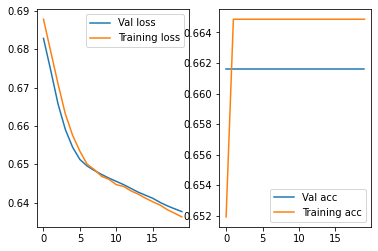

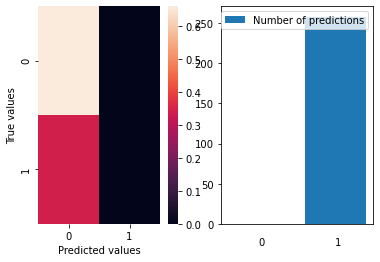

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.66      1.00      0.79       170
         1.0       0.00      0.00      0.00        88

    accuracy                           0.66       258
   macro avg       0.33      0.50      0.40       258
weighted avg       0.43      0.66      0.52       258

Nodes: (50, 500), Mean validation accuracy: 0.6616379022598267


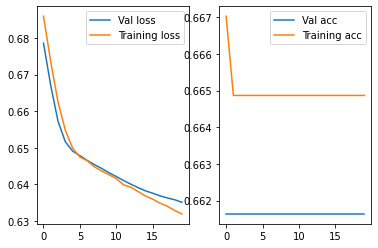

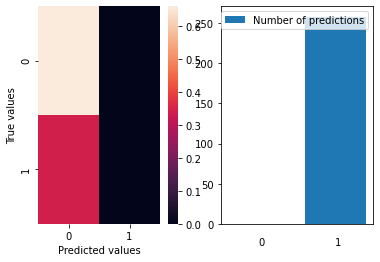

              precision    recall  f1-score   support

         0.0       0.66      1.00      0.79       170
         1.0       0.00      0.00      0.00        88

    accuracy                           0.66       258
   macro avg       0.33      0.50      0.40       258
weighted avg       0.43      0.66      0.52       258

Nodes: (50, 50), Mean validation accuracy: 0.6616379022598267


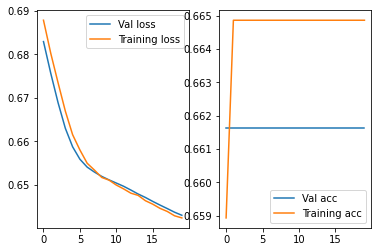

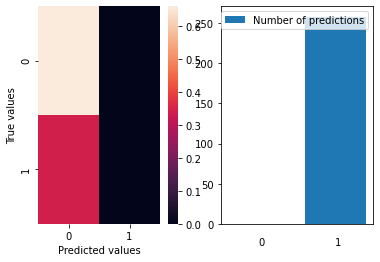

              precision    recall  f1-score   support

         0.0       0.66      1.00      0.79       170
         1.0       0.00      0.00      0.00        88

    accuracy                           0.66       258
   macro avg       0.33      0.50      0.40       258
weighted avg       0.43      0.66      0.52       258



In [31]:
for index in k_best: 
    Utilities.plot_history(results,index)
    y_test_pred_prob = model.predict(x_test)
    Utilities.test_summary(y_test, y_test_pred_prob)

In [30]:
with Notebook(): 
    reload(Utilities)